In [17]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(2022311328)

In [19]:
class MLP(nn.Module):
    def __init__(self,m,input,output):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,output)
        )
    def forward(self, x):
        return self.net(x)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
#边界条件，真值
def g(x,a):
    return torch.exp(x[:,0]*a)*torch.sin(x[:,1]*a)

In [22]:
def loss_binet(net,bd,y,W):
    res = torch.mean(torch.pow((W@net(y)-bd),2))
    return res

In [23]:
def loss_pinn(net,bd,x_in,x_bd):
    res = torch.mean(torch.pow(net(x_bd)-bd,2)).to(device)
    partial = torch.autograd.grad(net(x_in), x_in, torch.ones_like(net(x_in)).to(device), create_graph=True)[0]
    partial_11 = torch.autograd.grad(partial[:,0], x_in, torch.ones_like(partial[:,0]).to(device), create_graph=True)[0][:,0]
    partial_22 = torch.autograd.grad(partial[:,1], x_in, torch.ones_like(partial[:,0]).to(device), create_graph=True)[0][:,1]
    res += torch.mean(torch.pow(partial_11+partial_22,2))
    return res

In [24]:
num_epoch = 10000
m = 500
lr = 1e-4
M = 1200
a = 4
n_bd = 200
n_in = 1000

In [25]:
net_binet = MLP(m,2,1).to(device)

optim = torch.optim.Adam(net_binet.parameters(), lr = lr)

error_binet = torch.zeros(num_epoch)

#积分节点
theta = torch.linspace(2*np.pi/M,2*np.pi,M).reshape(-1,1)
temp = 9/20-1/9*torch.cos(5*theta)
y0,y1 = torch.cos(theta),torch.sin(theta)
y = (torch.cat((y0,y1),1)*temp).to(device)
sample_num = len(y)

#切向量
rprime = torch.cat((-y1*temp+5/9*torch.sin(5*theta)*y0,y0*temp+5/9*torch.sin(5*theta)*y1),1)
h = torch.cat((-y1*temp+5/9*torch.sin(5*theta)*y0,y0*temp+5/9*torch.sin(5*theta)*y1),1).norm(dim=1).to(device)
#法向量
normal = rprime@torch.Tensor([[0,-1],[1,0]])
normal = normal/((normal*normal).sum(axis=1).reshape(-1,1).sqrt())
normal = normal.to(device)

#积分权重
W = torch.zeros(sample_num,sample_num).to(device)
for i in range(sample_num):
    r = y - y[i,:]
    d = r.norm(dim=1)
    W[i,:] = 1/M*h*(r*normal).sum(axis=1)/(d*d)
    W[i,i] = 1/2

#边界条件
bd = g(y,a).reshape(len(y),1).to(device)

for epoch in range(num_epoch):
    l = loss_binet(net_binet,bd,y,W)
    with torch.no_grad():
        error_binet[epoch] = l
    optim.zero_grad()
    l.backward()
    optim.step()

epoch_binet = epoch
print(loss_binet(net_binet,bd,y,W))
print(error_binet[0:epoch+1].min())

tensor(3.2143e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.2156e-05)


In [26]:
net_pinn = MLP(m,2,1).to(device)

optim = torch.optim.Adam(net_pinn.parameters(), lr = lr)

error_pinn = torch.zeros(num_epoch)

theta = torch.linspace(2*np.pi/n_bd,2*np.pi,n_bd).reshape(-1,1)
temp = 9/20-1/9*torch.cos(5*theta)
y0,y1 = torch.cos(theta),torch.sin(theta)
x_bd = (torch.cat((y0,y1),1)*temp).to(device)

bd = g(x_bd,a).reshape(len(x_bd),1).to(device)


theta_r = torch.rand(n_in,2)*torch.tensor([2*torch.pi,1]).view(1,2)
theta_r[:,1] = 9/20-1/9*torch.cos(5*theta_r[:,0])
x_in = torch.zeros(n_in,2)
x_in[:,0] = torch.cos(theta_r[:,0])*theta_r[:,1]
x_in[:,1] = torch.sin(theta_r[:,0])*theta_r[:,1]

x_in.requires_grad = True
x_in = x_in.to(device)

for epoch in range(num_epoch):
    l = loss_pinn(net_pinn,bd,x_in,x_bd)
    with torch.no_grad():
        error_pinn[epoch] = l
    if epoch%1000==0:
        print('epoch:',epoch,'loss:',l)
    optim.zero_grad()
    l.backward()
    optim.step()

epoch_pinn = epoch
print(loss_pinn(net_pinn,bd,x_in,x_bd))
print(error_pinn[0:epoch+1].min())

epoch: 0 loss: tensor(5.5657, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 1000 loss: tensor(0.2654, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 2000 loss: tensor(0.1673, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 3000 loss: tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 4000 loss: tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 5000 loss: tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 6000 loss: tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 7000 loss: tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 8000 loss: tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 9000 loss: tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)


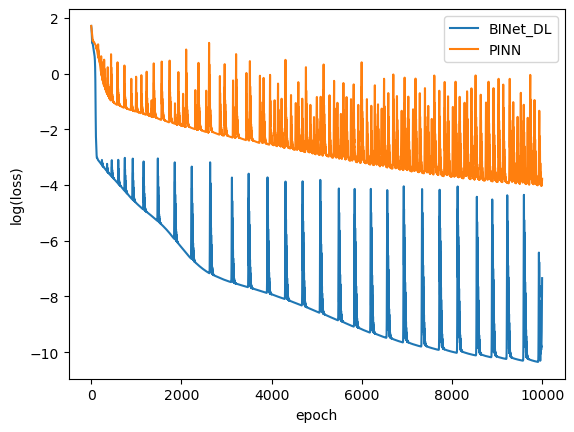

In [ ]:
plt.plot(np.arange(epoch_binet+1),np.log(error_binet[0:epoch_binet+1]),label='BINet_DL')
plt.plot(np.arange(epoch_pinn+1),np.log(error_pinn[0:epoch_pinn+1]),label='PINN')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.legend()
plt.show()

In [ ]:
def solve_binet(x,net,y,h):
    W = torch.zeros(len(x),len(y))
    for i in range(len(x)):
        r = y - x[i,:]
        d = r.norm(dim=1)
        W[i,:] = 1/M*h*(r*normal).sum(axis=1)/(d*d)
    W=torch.tensor(W, dtype=torch.float32)
    res = W@net(y)
    
    return res

C:\Users\GG\AppData\Local\Temp\ipykernel_26612\1516490291.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W=torch.tensor(W, dtype=torch.float32)


tensor(1.0270, grad_fn=<DivBackward0>)


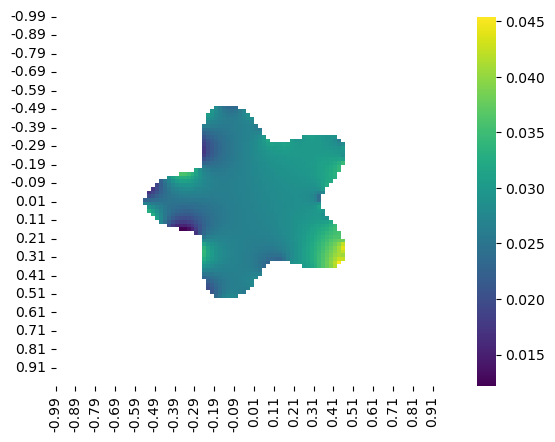

In [ ]:
n_test = 100
x1_test, x2_test = np.meshgrid(np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test),
                                np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test))

inputs = np.stack([x1_test, x2_test], axis=-1)
inputs = torch.tensor(inputs, dtype=torch.float32).view(-1, 2)

net_binet = net_binet.to('cpu')
y = y.to('cpu')
h = h.to('cpu')
normal = normal.to('cpu')

outputs = torch.abs(solve_binet(inputs, net_binet, y, h) - g(inputs, a).view(-1,1))
output = outputs.detach().numpy()
for i in range(inputs.size(0)):
    if inputs[i,1]>=0:
        phi = torch.acos(inputs[i,0]/inputs[i,:].norm())
    else:
        phi = 2*torch.pi - torch.acos(inputs[i,0]/inputs[i,:].norm())
    if inputs[i,:].norm()>9/20-1/9*torch.cos(5*phi)-0.01:
        output[i] = None

output = output.reshape((n_test,n_test))


print((solve_binet(inputs, net_binet, y, h) - g(inputs, a).view(-1,1)).norm() / g(inputs, a).norm())

label_interval = 5
label = np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test)[::label_interval]
label = [f'{label_val:.2f}' for label_val in label]

sns.heatmap(output, cmap='viridis', xticklabels=label, yticklabels=label)

plt.xticks(np.arange(0, n_test, label_interval), labels=label)
plt.yticks(np.arange(0, n_test, label_interval), labels=label)
plt.show()

tensor(0.8368, grad_fn=<DivBackward0>)


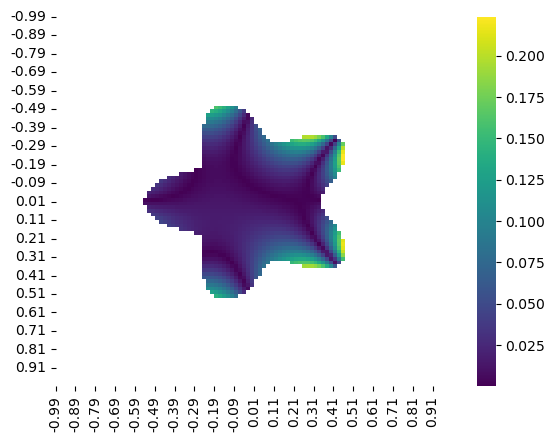

In [ ]:
n_test = 100
x1_test, x2_test = np.meshgrid(np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test),
                                np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test))

inputs = np.stack([x1_test, x2_test], axis=-1)
inputs = torch.tensor(inputs, dtype=torch.float32).view(-1, 2)

net_pinn = net_pinn.to('cpu')
normal = normal.to('cpu')

outputs = torch.abs(net_pinn(inputs) - g(inputs, a).view(-1,1))
output = outputs.detach().numpy()
for i in range(inputs.size(0)):
    if inputs[i,1]>=0:
        phi = torch.acos(inputs[i,0]/inputs[i,:].norm())
    else:
        phi = 2*torch.pi - torch.acos(inputs[i,0]/inputs[i,:].norm())
    if inputs[i,:].norm()>9/20-1/9*torch.cos(5*phi)-0.01:
        output[i] = None

output = output.reshape((n_test,n_test))


print((net_pinn(inputs) - g(inputs, a).view(-1,1)).norm() / g(inputs, a).norm())

label_interval = 5
label = np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test)[::label_interval]
label = [f'{label_val:.2f}' for label_val in label]

sns.heatmap(output, cmap='viridis', xticklabels=label, yticklabels=label)

plt.xticks(np.arange(0, n_test, label_interval), labels=label)
plt.yticks(np.arange(0, n_test, label_interval), labels=label)
plt.show()